In [130]:
import requests
import re
import json

def extract_json_from_html(url, save_output=False):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the HTML content. Status code: {}".format(response.status_code)

    html = response.text
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    match = re.findall(regex_pattern, html)
    if not match:
        return "No match found"

    # Correcting data format by adding quotes around keys
    data_txt = match[0]
    keys_to_replace = ['matchId', 'matchCentreData', 'matchCentreEventTypeJson', 'formationIdNameMappings']
    for key in keys_to_replace:
        data_txt = data_txt.replace(key, f'"{key}"')
    data_txt = data_txt.replace('};', '}')

    # Try to parse the JSON data
    try:
        data_json = json.loads(data_txt)
    except json.JSONDecodeError:
        return "JSON decoding failed"

    # Print the JSON structure summarization
    print_json_structure(data_json)

    # Optionally, save the JSON data to a text file
    if save_output:
        output_filename = 'output.txt'
        with open(output_filename, 'w', encoding='utf-8') as output_file:
            json.dump(data_json, output_file, indent=4)

    return data_json

def print_json_structure(data, indent=0, max_list_example=3):
    for key, value in data.items():
        if isinstance(value, dict):
            print('  ' * indent + f"{key} (dict with {len(value.keys())} keys)")
            print_json_structure(value, indent + 1)
        elif isinstance(value, list):
            print('  ' * indent + f"{key} (list with {len(value)} items)")
            if value:
                if isinstance(value[0], dict):
                    print('  ' * (indent + 1) + f"Example item from list:")
                    print_json_structure(value[0], indent + 2)
                else: 
                    example_items = value[:max_list_example]
                    print('  ' * (indent + 1) + f"Example items: {example_items}")
        else:
            print('  ' * indent + f"{key} ({type(value).__name__})")



In [131]:
## replace with the match wanted to scrape
url = "https://www.whoscored.com/Matches/1809761/Live/Europe-Champions-League-2023-2024-Real-Madrid-Manchester-City"
data = extract_json_from_html(url, save_output=True)


matchId (int)
matchCentreData (dict with 28 keys)
  playerIdNameDictionary (dict with 43 keys)
    347862 (str)
    337782 (str)
    337879 (str)
    20874 (str)
    296337 (str)
    353423 (str)
    369109 (str)
    31772 (str)
    104010 (str)
    317541 (str)
    74603 (str)
    106875 (str)
    106883 (str)
    113880 (str)
    144511 (str)
    144890 (str)
    415181 (str)
    345031 (str)
    344644 (str)
    379868 (str)
    422957 (str)
    482830 (str)
    365409 (str)
    388098 (str)
    73084 (str)
    121774 (str)
    93894 (str)
    402664 (str)
    133569 (str)
    315227 (str)
    430709 (str)
    394933 (str)
    313171 (str)
    136741 (str)
    303139 (str)
    355110 (str)
    449161 (str)
    297390 (str)
    8155 (str)
    331254 (str)
    101374 (str)
    113069 (str)
    444791 (str)
  periodMinuteLimits (dict with 4 keys)
    1 (int)
    2 (int)
    3 (int)
    4 (int)
  timeStamp (str)
  attendance (int)
  venueName (str)
  referee (dict with 5 keys)
    offic

In [132]:
import pandas as pd
import json

def extract_data_from_dict(data):
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {
        data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
        data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']
    }
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]

    # Creating players dataframes
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']

    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']

    # Combine the home and away players into a single DataFrame
    players_df = pd.concat([players_home_df, players_away_df], ignore_index=True)

    return events_dict, players_df, teams_dict


In [133]:
import pandas as pd

def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # Filter only passes with outcomeType equal to "Successful"
    df_passes = df[(df['eventType'] == 'Pass') & (df['outcomeType'] == 'Successful')]

    # Create receiver column based on the next event
    # This will be correct only for successful passes
    df_passes["receiver"] = df_passes["playerId"].shift(-1)

    # Keep only relevant columns
    df_passes = df_passes[["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes


In [134]:
events_dict, players_df, teams_dict = extract_data_from_dict(data)
print(teams_dict)
passes_df = get_passes_df(events_dict)
passes_df.head()

{52: 'Real Madrid', 167: 'Man City'}


C:\Users\2998542\AppData\Local\Temp\ipykernel_13720\951560948.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes["receiver"] = df_passes["playerId"].shift(-1)


,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.670323e+09,50.0,50.0,27.0,50.8,167,93894.0,133569.0,Pass,Successful
3,2.670323e+09,28.5,42.0,69.3,14.4,167,133569.0,347862.0,Pass,Successful
6,2.670323e+09,39.5,97.4,55.4,96.2,52,347862.0,113069.0,Pass,Successful
10,2.670323e+09,23.2,54.6,18.5,64.1,167,113069.0,402664.0,Pass,Successful
11,2.670323e+09,26.9,83.5,41.0,67.2,167,402664.0,337782.0,Pass,Successful


In [135]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    print(team_id)
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    print(average_locs_and_count_df)

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = pd.pivot_table(passes_player_ids_df, 
                                    index=['pos_min', 'pos_max'], 
                                    values='id', 
                                    aggfunc='count').reset_index()
    passes_between_df.rename(columns={'id': 'pass_count'}, inplace=True)


    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [136]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
home_passes_between_df

# Using len() function
num_passes = len(home_passes_between_df)
print("Number of passes:", num_passes)

# Using .shape attribute
num_passes_alt = home_passes_between_df.shape[0]
print("Number of passes (alternative method):", num_passes_alt)


52
                  x          y  count                 name  shirtNo position
playerId                                                                    
31772.0   42.030189  66.198113     53           Toni Kroos        8      DMC
104010.0  31.526829  69.970732     41      Antonio Rüdiger       22       DC
106883.0  52.003125  10.734375     32        Dani Carvajal        2       DR
296337.0  48.091304  89.213043     23        Ferland Mendy       23       DL
337782.0  66.340909  79.704545     22      Vinícius Júnior        7       FW
344644.0  53.777273  28.540909     22    Federico Valverde       15      AMR
345031.0   9.157692  50.100000     26         Andriy Lunin       13       GK
347862.0  62.740909  72.195455     22              Rodrygo       11      AML
353423.0  29.649020  35.784314     51  Aurélien Tchouaméni       18       DC
369109.0  48.611111  45.252778     36    Eduardo Camavinga       12      DMC
379868.0  57.600000  61.596296     27      Jude Bellingham        5      

In [137]:
import itertools

def find_missing_passes(passes_between_df, average_locs_and_count_df):
    # Extract player IDs
    player_ids = average_locs_and_count_df.index.tolist()
    
    # Generate all possible combinations of player pairs
    all_possible_pairs = list(itertools.combinations(player_ids, 2))
    
    # Extract the player pairs that occurred in passes_between_df
    occurred_pairs = set(zip(passes_between_df['pos_min'], passes_between_df['pos_max']))
    
    # Find missing passes
    missing_passes = [pair for pair in all_possible_pairs if pair not in occurred_pairs]
    
    return missing_passes

# Assuming you have the DataFrame home_passes_between_df and average_locs_and_count_df
missing_passes = find_missing_passes(home_passes_between_df, home_average_locs_and_count_df)

print("Missing Passes:")
for pair in missing_passes:
    player1_name = home_average_locs_and_count_df.loc[pair[0], 'name']
    player2_name = home_average_locs_and_count_df.loc[pair[1], 'name']
    print(f"{player1_name} -> {player2_name}")


Missing Passes:
Antonio Rüdiger -> Rodrygo
Dani Carvajal -> Ferland Mendy
Dani Carvajal -> Vinícius Júnior
Vinícius Júnior -> Federico Valverde
Vinícius Júnior -> Aurélien Tchouaméni
Vinícius Júnior -> Eduardo Camavinga
Federico Valverde -> Andriy Lunin
Andriy Lunin -> Rodrygo
Andriy Lunin -> Jude Bellingham
Rodrygo -> Aurélien Tchouaméni


In [138]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)
away_passes_between_df.head()

num_passes = len(away_passes_between_df)
print("Number of passes:", num_passes)

# Using .shape attribute
num_passes_alt = away_passes_between_df.shape[0]
print("Number of passes (alternative method):", num_passes_alt)

167
                  x          y  count            name  shirtNo position
playerId                                                               
93894.0   55.998413  61.260317     63   Mateo Kovacic        8      DMC
101374.0  52.372131  41.172131     61     John Stones        5       DC
113069.0  63.748276  81.010345     29   Jack Grealish       10      AML
133569.0  11.891176  49.276471     34   Stefan Ortega       18       GK
136741.0  63.710526  19.491228     57  Bernardo Silva       20      AMR
297390.0  50.421687  14.466265     83   Manuel Akanji       25       DR
303139.0  51.828814  44.975424    118           Rodri       16      DMC
313171.0  39.470370  44.297531     81      Rúben Dias        3       DC
315227.0  72.450000  49.000000      6  Erling Haaland        9       FW
331254.0  61.488372  27.048837     43      Phil Foden       47      AMC
402664.0  52.525373  73.888060     67  Josko Gvardiol       24       DL
Number of passes: 52
Number of passes (alternative method): 

### Visualization

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [140]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        print(row)
        player_name = row["name"].split()
        player_shirt_no = row["shirtNo"]
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_shirt_no, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

x               42.030189
y               66.198113
count                  53
name           Toni Kroos
shirtNo                 8
position              DMC
marker_size        3000.0
Name: 31772.0, dtype: object
x                    31.526829
y                    69.970732
count                       41
name           Antonio Rüdiger
shirtNo                     22
position                    DC
marker_size        2320.754717
Name: 104010.0, dtype: object
x                  52.003125
y                  10.734375
count                     32
name           Dani Carvajal
shirtNo                    2
position                  DR
marker_size      1811.320755
Name: 106883.0, dtype: object
x                  48.091304
y                  89.213043
count                     23
name           Ferland Mendy
shirtNo                   23
position                  DL
marker_size      1301.886792
Name: 296337.0, dtype: object
x                    66.340909
y                    79.704545
count         

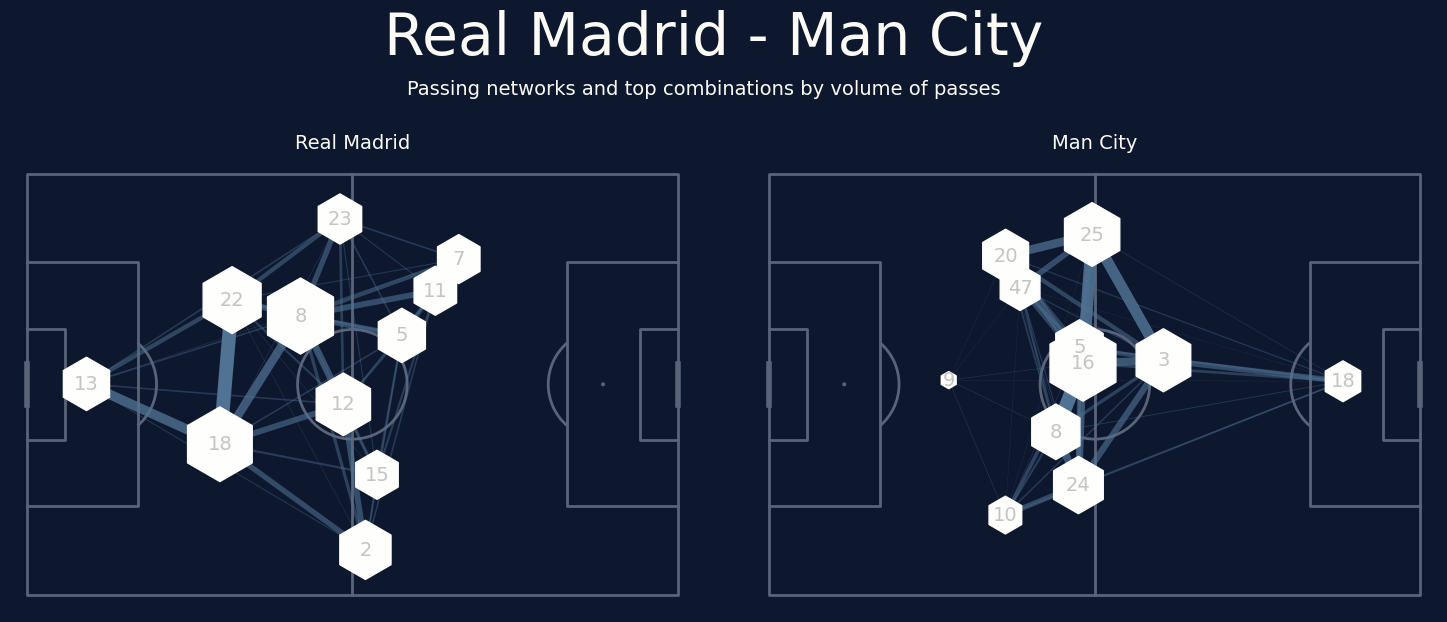

In [141]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14 )

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

## Netwrok analysis

In [142]:
# Filter passes where the outcomeType is "Successful"
successful_passes_df = passes_df[passes_df["outcomeType"] == "Successful"]

# Filter passes where the outcomeType is not "Successful" (i.e., unsuccessful passes)
unsuccessful_passes_df = passes_df[passes_df["outcomeType"] != "Successful"]

# Print the DataFrame containing unsuccessful passes
print("\nUnsuccessful Passes:")
print(unsuccessful_passes_df)



Unsuccessful Passes:
Empty DataFrame
Columns: [id, x, y, endX, endY, teamId, playerId, receiver, eventType, outcomeType]
Index: []


In [143]:
import pandas as pd

def get_directed_passes_between_df(team_id, passes_df, players_df):
    # Filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]
    # Filter passes where the outcomeType is "Successful"
    passes_df = passes_df[passes_df["outcomeType"] == "Successful"]

    # Filter for first eleven players
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

   

    # Calculate mean positions for players
    average_locs_and_count_df = passes_df.groupby('playerId').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # Get passes between each player
    passes_between_df = passes_df.groupby(['playerId', 'receiver']).size().reset_index(name='pass_count')

    # Merge player location data
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='playerId', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='receiver', right_index=True,
                                                suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df


away_directed_passes_between_df, away_average_locs_and_count_df = get_directed_passes_between_df(away_team_id, successful_passes_df, players_df)
away_directed_passes_between_df.head()
away_num_directed_passes = len(away_directed_passes_between_df)
print("Away Number of directed passes:", away_num_directed_passes)

home_directed_passes_between_df, home_average_locs_and_count_df = get_directed_passes_between_df(home_team_id, successful_passes_df, players_df)
home_directed_passes_between_df.head()
home_num_directed_passes = len(home_directed_passes_between_df)
print("home Number of directed passes:", home_num_directed_passes)



Away Number of directed passes: 91
home Number of directed passes: 81


In [144]:
away_directed_passes_between_df

,playerId,receiver,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end
0,93894.0,101374.0,3,55.998413,61.260317,63,Mateo Kovacic,8,DMC,52.372131,41.172131,61,John Stones,5,DC
29,113069.0,101374.0,1,63.748276,81.010345,29,Jack Grealish,10,AML,52.372131,41.172131,61,John Stones,5,DC
41,133569.0,101374.0,3,11.891176,49.276471,34,Stefan Ortega,18,GK,52.372131,41.172131,61,John Stones,5,DC
50,136741.0,101374.0,4,63.710526,19.491228,57,Bernardo Silva,20,AMR,52.372131,41.172131,61,John Stones,5,DC
62,297390.0,101374.0,9,50.421687,14.466265,83,Manuel Akanji,25,DR,52.372131,41.172131,61,John Stones,5,DC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,303139.0,93894.0,25,51.828814,44.975424,118,Rodri,16,DMC,55.998413,61.260317,63,Mateo Kovacic,8,DMC
93,313171.0,93894.0,6,39.470370,44.297531,81,Rúben Dias,3,DC,55.998413,61.260317,63,Mateo Kovacic,8,DMC
105,315227.0,93894.0,1,72.450000,49.000000,6,Erling Haaland,9,FW,55.998413,61.260317,63,Mateo Kovacic,8,DMC
110,331254.0,93894.0,5,61.488372,27.048837,43,Phil Foden,47,AMC,55.998413,61.260317,63,Mateo Kovacic,8,DMC


In [145]:
import pandas as pd
import networkx as nx
from IPython.display import display
import itertools

def analyze_pass_network(passes_df, min_passes, exclude_players=None):
    """
    Analyze the pass network from a DataFrame of passes between players.
    
    Parameters:
    - passes_df: DataFrame containing pass data.
    - min_passes: Minimum number of passes required to consider an edge valid.

    Returns:
    - A dictionary containing centrality measures, network properties, and triads.
    """
    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges from DataFrame with filtering based on min_passes
    for idx, row in passes_df.iterrows():
        if row['pass_count'] >= min_passes:
            G.add_edge(row['name'], row['name_end'], weight=row['pass_count'])

    # Calculate centrality measures
    centrality_measures = {
        'betweenness': nx.betweenness_centrality(G, weight='weight'),
        'in_degree': nx.in_degree_centrality(G),
        'out_degree': nx.out_degree_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'degree': nx.degree_centrality(G),
        'eigenvector': nx.eigenvector_centrality_numpy(G) if nx.is_connected(G.to_undirected()) else {}
    }

    # Calculate network properties
    network_properties = {
        'density': nx.density(G),
        'average_degree': sum(dict(G.degree()).values()) / float(G.number_of_nodes()),
        'transitivity': nx.transitivity(G),
        'clustering_coefficient': calculate_clustering_coefficient(G),
        'average_shortest_path_length': nx.average_shortest_path_length(G)  # Use the default (unweighted) version
    }

    # Calculate triad properties
    triad_properties = calculate_triad_properties(G, exclude_players=exclude_players)
    
    return {
        'centrality_measures': centrality_measures,
        'network_properties': network_properties,
        'triad_properties': triad_properties
    }

def calculate_clustering_coefficient(G):
    """
    Calculate the clustering coefficient for a directed graph G.
    
    Parameters:
    - G: Directed graph object.
    
    Returns:
    - Clustering coefficient value.
    """
    clustering_coefficient = {}

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        num_neighbors = len(neighbors)

        if num_neighbors < 2:
            clustering_coefficient[node] = 0.0
            continue

        total_possible_edges = num_neighbors * (num_neighbors - 1)
        actual_edges = sum(1 for v, w in itertools.permutations(neighbors, 2) if G.has_edge(v, w))
        clustering_coefficient[node] = actual_edges / total_possible_edges if total_possible_edges > 0 else 0

    avg_clustering_coefficient = sum(clustering_coefficient.values()) / len(clustering_coefficient) if clustering_coefficient else 0
    return avg_clustering_coefficient

def calculate_triad_properties(G, exclude_players=None):
    """
    Calculate properties of all triads in the directed graph G, excluding specified players.
    
    Parameters:
    - G: Directed graph object.
    - exclude_players: List of player names to exclude from the analysis (optional).
    
    Returns:
    - A list of dictionaries containing node sets and their respective properties such as weight and transitivity.
    """
    # Remove excluded players from the graph for analysis
    if exclude_players:
        G = G.copy()  # Create a copy of the graph to modify it without affecting the original
        G.remove_nodes_from(exclude_players)
        print("Remaining nodes after exclusion:", G.nodes())  # Debugging statement


    triads = itertools.combinations(G.nodes(), 3)
    triad_properties = []

    for triad in triads:
        subgraph = G.subgraph(triad)
        if subgraph.number_of_edges() < 3:
            continue  # Only consider complete triads with all three connections

        # Calculate total weight of edges within the triad
        total_weight = sum([data['weight'] for u, v, data in subgraph.edges(data=True)])
        # Calculate transitivity for the triad
        local_transitivity = nx.transitivity(subgraph)

        triad_properties.append({
            'nodes': triad,
            'total_weight': total_weight,
            'transitivity': local_transitivity
        })

    # Sort triads by total weight and transitivity
    triad_properties.sort(key=lambda x: (-x['total_weight'], -x['transitivity']))

    return triad_properties


# Define the players to be excluded from triad analsysis
exclude_players = ['Stefan Ortega', 'Rúben Dias','Josko Gvardiol']  # Example names, replace with actual player names

# home_passes_between_df = pd.read_csv('path_to_your_dataframe.csv')
result = analyze_pass_network(away_directed_passes_between_df, min_passes=3,exclude_players=exclude_players)

# Extract centrality measures
centrality_measures = result['centrality_measures']
centrality_measures_df = pd.DataFrame(centrality_measures)

# Extract network properties
network_properties = result['network_properties']
network_properties_df = pd.DataFrame(network_properties.items(), columns=['Property', 'Value'])

# Extract triad properties
triad_properties = result['triad_properties']
triad_properties_df = pd.DataFrame(triad_properties)
triad_properties_df['nodes'] = triad_properties_df['nodes'].apply(lambda x: ', '.join(x))
triad_properties_df = triad_properties_df.sort_values(by=['transitivity', 'total_weight'], ascending=[False, False])

# Display network properties
print("Network Properties:")
display(network_properties_df)

# Display centrality measures
print("\nCentrality Measures:")
display(centrality_measures_df)

# Display triad properties
print("\nTriad Properties (Top 5):")
display(triad_properties_df.head(5))



Remaining nodes after exclusion: ['Mateo Kovacic', 'John Stones', 'Bernardo Silva', 'Manuel Akanji', 'Rodri', 'Phil Foden', 'Jack Grealish']
Network Properties:


,Property,Value
0,density,0.711111
1,average_degree,12.800000
2,transitivity,0.762295
3,clustering_coefficient,0.787738
4,average_shortest_path_length,1.288889



Centrality Measures:


,betweenness,in_degree,out_degree,closeness,degree,eigenvector
Mateo Kovacic,0.166667,0.777778,0.777778,0.818182,1.555556,0.341077
John Stones,0.118056,0.888889,0.888889,0.900000,1.777778,0.377050
Stefan Ortega,0.125000,0.444444,0.444444,0.642857,0.888889,0.206445
Bernardo Silva,0.048611,0.666667,0.777778,0.750000,1.444444,0.306601
Manuel Akanji,0.000000,0.555556,0.666667,0.692308,1.222222,0.262248
Rodri,0.000000,1.000000,0.888889,1.000000,1.888889,0.402025
Rúben Dias,0.041667,0.888889,0.888889,0.900000,1.777778,0.362155
Phil Foden,0.145833,0.666667,0.666667,0.750000,1.333333,0.306601
Josko Gvardiol,0.076389,0.777778,0.666667,0.818182,1.444444,0.335309
Jack Grealish,0.069444,0.444444,0.444444,0.642857,0.888889,0.192057



Triad Properties (Top 5):


,nodes,total_weight,transitivity
0,"Bernardo Silva, Manuel Akanji, Rodri",90,1.0
2,"John Stones, Manuel Akanji, Rodri",84,1.0
3,"Mateo Kovacic, John Stones, Rodri",82,1.0
4,"Mateo Kovacic, Bernardo Silva, Rodri",74,1.0
5,"Manuel Akanji, Rodri, Phil Foden",73,1.0


TypeError: BasePitchPlot.heatmap() got multiple values for argument 'ax'

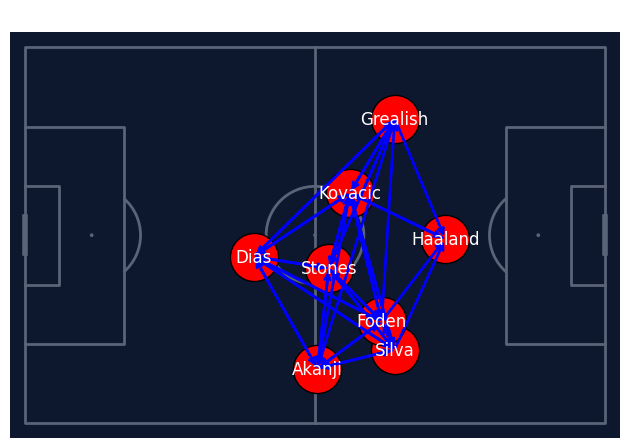

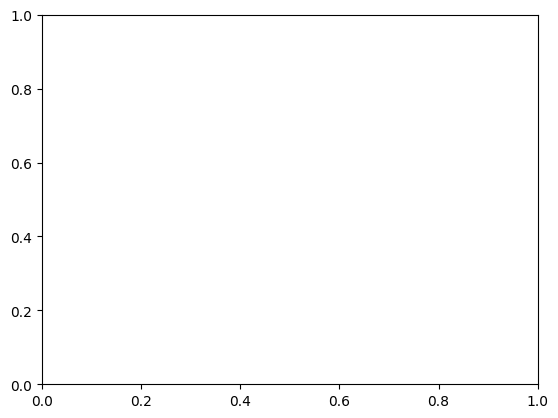

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch

# Function to plot the directed pass network with uniform line widths and circle sizes
def pass_network_visualization(ax, passes_df, player_df, exclude_players=None):
    line_width = 2  # Set a fixed line width for all passes
    marker_size = 1200  # Set a fixed marker size for all players

    # Filter out excluded players and corresponding lines
    if exclude_players:
        passes_df = passes_df[~passes_df['name'].isin(exclude_players) & ~passes_df['name_end'].isin(exclude_players)]
        player_df = player_df[~player_df['name'].isin(exclude_players)]

    # Plot passes with a fixed arrow style
    for _, row in passes_df.iterrows():
        ax.annotate('', xy=(row['x_end'], row['y_end']), xytext=(row['x'], row['y']),
                    arrowprops=dict(arrowstyle="->", color='blue', lw=line_width))

    # Plot player nodes with a fixed size
    scatter = ax.scatter(player_df['x'], player_df['y'], s=marker_size, color='red', edgecolors='black', zorder=2)

    # Add player names or shirt numbers
    for idx, row in player_df.iterrows():
        ax.text(row['x'], row['y'], str(row['name'].split()[-1]), color='white', fontsize=12,
                ha='center', va='center', zorder=3)

# Assuming you have already imported the away_directed_passes_between_df DataFrame
# Define the DataFrame for passes and player locations
passes_df = away_directed_passes_between_df[['x', 'y', 'x_end', 'y_end', 'pass_count', 'name', 'name_end']]
player_df = away_directed_passes_between_df[['x', 'y', 'count', 'name', 'shirtNo']].drop_duplicates(subset=['name'])

# Define a list of players to exclude from the visualization
exclude_players = ['Rodri', 'Stefan Ortega', 'Josko Gvardiol']  

# Create the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
fig, ax = pitch.draw()

# Plotting the network with excluded players and corresponding lines
pass_network_visualization(ax, passes_df, player_df, exclude_players=exclude_players)

# Add titles and show the plot
plt.title('Directed Pass Network', color='white', fontsize=14)

# Adding a heatmap behind the network
heatmap = pitch.heatmap(away_directed_passes_between_df['x'], away_directed_passes_between_df['y'], ax=ax, cmap='hot', bins=20)
plt.show()
